In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm, trange

import sys
sys.path.append("src")  # hacky way to get access to the util.save_perf
from util import save_perf

In [5]:
adata_sc = ad.read_h5ad("data/COMBAT/COMBAT-CITESeq-DATA-top2000.h5ad")

In [7]:
SAMPLE_COL = "Donor ID"
# CELLTYPE_COL = "Annotation_minor_subset"
LABEL = "SARSCoV2PCR"
TOTAL_COUNTS_COL = "QC_total_UMI"

In [ ]:
DONORS = sorted(adata_sc.obs[SAMPLE_COL].unique())

x = np.zeros((len(DONORS), adata_sc.shape[1]))

for i, donor in enumerate(tqdm(DONORS)):
    adata_donor = adata_sc[adata_sc.obs[SAMPLE_COL] == donor]

    donor_x = adata_donor.X.todense()

    # undo log transformation
    donor_x = np.expm1(donor_x)

    # inflate cells to original counts
    for j in range(donor_x.shape[0]):
        donor_xj_sum = donor_x[j].sum()
        if donor_xj_sum > 0:
            donor_x[j] = donor_x[j] * adata_donor.obs[TOTAL_COUNTS_COL].values[j] / donor_xj_sum
        else:
            donor_x[j] = 0
            print(f"Warning: all zero counts for cell {j} of donor {donor}.")

    # aggregate all cells of this donor to simulate bulk
    x[i] = donor_x.sum(axis=0) 

adata = ad.AnnData(x, obs=adata_sc.obs[adata_sc.obs["Donor ID"].isin(DONORS)].groupby(SAMPLE_COL, observed=True).first(), var=adata_sc.var)
adata.obs["Donor ID"] = DONORS

100%|██████████| 140/140 [00:25<00:00,  5.46it/s]
C:\Users\timo\AppData\Local\Temp\ipykernel_43644\1296349224.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata = ad.AnnData(x, obs=adata_sc.obs[adata_sc.obs["Donor ID"].isin(DONORS)].groupby(SAMPLE_COL).first(), var=adata_sc.var)


In [16]:
X = adata.X
Y = adata.obs[LABEL].values

X = X / X.sum(axis=1).reshape(-1, 1) * 1e4
# X = np.log1p(X)
X = (X - X.mean(axis=0)) / X.std(axis=0)

<Axes: >

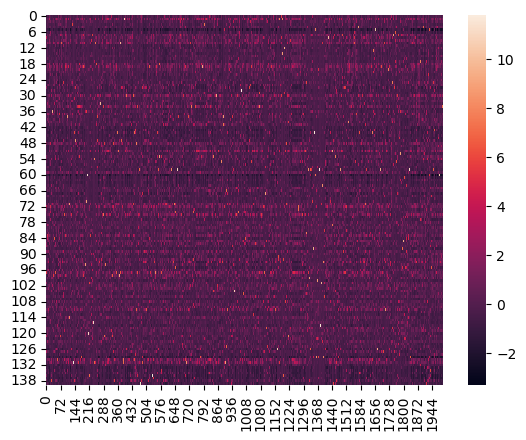

In [17]:
sns.heatmap(X)

In [27]:
N_RUNS = 100
N_FOLDS = 5
# SPLIT_SEED = None
SPLIT_SEED = 42

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

mean_accs = np.zeros(N_RUNS)
mean_prec = np.zeros(N_RUNS)
mean_rec = np.zeros(N_RUNS)
mean_f1 = np.zeros(N_RUNS)
mean_auc = np.zeros(N_RUNS)

y_pred = []

for j in trange(N_RUNS):

    if SPLIT_SEED is not None:
        kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SPLIT_SEED)
    else:
        kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True)

    test_accs = []
    test_prec = []
    test_rec = []
    test_f1 = []
    test_auc = []
    
    y_pred.append([])

    for i, (train_index, test_index) in enumerate(kf.split(X, Y)):
        
        X_train = X[train_index]
        Y_train = Y[train_index]
        
        X_test = X[test_index]
        Y_test = Y[test_index]
        
        model = Lasso(alpha=0.03)
        model.fit(X_train, Y_train)
        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        auc = roc_auc_score(Y_test, y_pred_test)
        
        test_auc.append(auc)

        y_pred_train = (y_pred_train > 0.5).astype(int)
        y_pred_test = (y_pred_test > 0.5).astype(int)
        
        y_pred[j].append(y_pred_test)
        
        acc_train = (y_pred_train == Y_train).mean()
        acc_test = (y_pred_test == Y_test).mean()
        
        acc = accuracy_score(Y_test, y_pred_test)
        prec = precision_score(Y_test, y_pred_test)
        rec = recall_score(Y_test, y_pred_test)
        f1 = f1_score(Y_test, y_pred_test)
        
        test_accs.append(acc)
        test_prec.append(prec)  
        test_rec.append(rec)
        test_f1.append(f1)

        if j == 0:
            train_donors = adata.obs[SAMPLE_COL].values[train_index]
            test_donors = adata.obs[SAMPLE_COL].values[test_index]
            save_perf(
                exp_name="COMBAT_top2000",
                model_name="Pseudobulk",
                fold=i,
                accuracy=acc,
                precision=prec,
                recall=rec,
                f1=f1,
                roc_auc=auc,
                train_donors=train_donors,
                test_donors=test_donors,
                train_y=Y_train.flatten(),
                test_y=Y_test.flatten(),
                train_y_pred=y_pred_train.flatten(),
                test_y_pred=y_pred_test.flatten(),
                processing="cpm=True, log1p=False, standardize=True",
            )
            print(f"Fold {i+1}/{N_FOLDS} - Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    
    mean_accs[j] = np.mean(test_accs)
    mean_prec[j] = np.mean(test_prec)
    mean_rec[j] = np.mean(test_rec)
    mean_f1[j] = np.mean(test_f1)
    mean_auc[j] = np.mean(test_auc)
    
print(f"Mean test  acc: {np.mean(mean_accs):.4f} +/- {np.std(mean_accs):.4f}")
print(f"Mean test prec: {np.mean(mean_prec):.4f} +/- {np.std(mean_prec):.4f}")
print(f"Mean test  rec: {np.mean(mean_rec):.4f} +/- {np.std(mean_rec):.4f}")
print(f"Mean test   f1: {np.mean(mean_f1):.4f} +/- {np.std(mean_f1):.4f}")
print(f"Mean test  auc: {np.mean(mean_auc):.4f} +/- {np.std(mean_auc):.4f}")

print()

print("acc =", mean_accs)
print("prec =", mean_prec)
print("rec =", mean_rec)
print("f1 =", mean_f1)
print("auc =", mean_auc)

  1%|          | 1/100 [00:00<00:13,  7.37it/s]

Fold 1/5 - Acc: 0.8929, Prec: 0.9000, Rec: 0.9474, F1: 0.9231, AUC: 0.9825
Fold 2/5 - Acc: 0.9643, Prec: 0.9500, Rec: 1.0000, F1: 0.9744, AUC: 0.9708
Fold 3/5 - Acc: 0.9286, Prec: 0.9048, Rec: 1.0000, F1: 0.9500, AUC: 0.9708
Fold 4/5 - Acc: 0.8929, Prec: 0.8571, Rec: 1.0000, F1: 0.9231, AUC: 0.9556
Fold 5/5 - Acc: 0.8929, Prec: 0.8571, Rec: 1.0000, F1: 0.9231, AUC: 1.0000


100%|██████████| 100/100 [00:11<00:00,  8.85it/s]

Mean test  acc: 0.9143 +/- 0.0000
Mean test prec: 0.8938 +/- 0.0000
Mean test  rec: 0.9895 +/- 0.0000
Mean test   f1: 0.9387 +/- 0.0000
Mean test  auc: 0.9759 +/- 0.0000

acc = [0.91428571 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571
 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571
 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571
 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571
 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571
 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571
 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571
 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571
 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571
 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571
 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571
 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571 0.91428571
 0.91428571 0.91428